# Linear Algebraic Background Subtraction For Femtosecond Timing

## Intro

This notebook demonstrates how to perform a linear algebraic based background subtraction for isolating the edge in femto second x-ray/laser timing recovery. (SVD of signals themselves are shown too.)

Based on "Singular value decomposition as a tool for background corrections in time-resolved XFEL scattering data", Kristoffer Haldrup,Philosophical Transactions of the Royal Society B: Biological Sciences, page 20130336
June 4, 2014

## Loading Libraries

In [78]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import os
import recalculating_attm_data_package as eig_back
import sys

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import GridSearchCV

sys.path.append("/reg/neh/home5/sioan/Desktop/git_version_controlled/bcv_spectral_clustering/lib")
import bi_cross_support
from importlib import reload

## Initializing Data

### Loading Data

In [2]:
#load data
experiment_run_name = "xpptut15run420.h5"
my_file = experiment_run_name
my_hdf5_object = h5py.File(my_file,"r")

### Converting hdf5 to Python Dictionary

In [3]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])
pixel_to_femtosecond_list = []
width_list = []

## Visualizing Some Sample Data

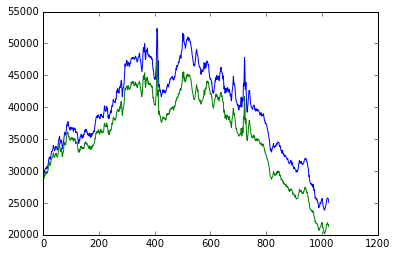

In [4]:
#plot some sample data
time_camera = 'timeToolOpal'
plot(my_dict[time_camera][0])
plot(my_dict[time_camera][3000])
show()

## Isolating and Displaying Some Sample Backgrounds

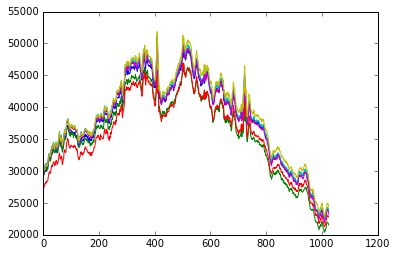

In [5]:
#identify background shots and plot some of them
my_dropped_shots = array(my_dict['evr/code_162']==1)              #this creates an array of booleans for dropped shots
atm_backgrounds = my_dict[time_camera][my_dropped_shots][::1]    #using the boolean array to select the dropped shots
plot(atm_backgrounds[30::400].transpose())
show()

In [6]:
atm_backgrounds.shape

(2145, 1024)

##  Eigen-Backgrounds package testing

In [7]:
reload(eig_back)

<module 'recalculating_attm_data_package' from '/reg/g/psdm/sw/hutch/sxd/analysis_methods/eigen_background_subtraction/recalculating_attm_data_package.py'>

In [8]:
my_mask = my_dict[time_camera][0].astype(bool)
my_mask[0:500]=True
my_mask[500:900]=False
my_mask[900:]=True

In [9]:
my_dict[time_camera].shape

(15015, 1024)

In [118]:
background_subtracted = eig_back.subtract_background(my_dict[time_camera],
                                                     my_dropped_shots,
                                                     my_mask,
                                                     svd_size=15)
                            
                             

subtracting background
getting background coefficients
dropped shots selected
(2145, 1024)
transpose dot product
eigen values calculated


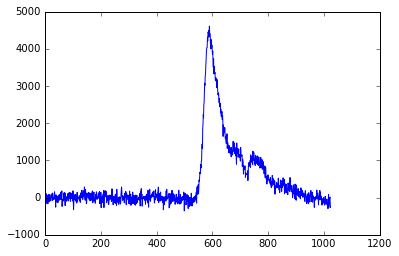

In [18]:
plt.plot(np.real(background_subtracted)[500])
plt.show()

In [19]:
pixel_positions,pixel_position_cov = eig_back.get_edge_position(background_subtracted,savgol_win_size = 21,fit_range=4)

Progress: [####################] 100.0%


In [20]:
pixel_positions

array([ 247.69687868,  521.27232017,  577.69360753, ...,  584.88385261,
        532.57507623,  614.74780114])

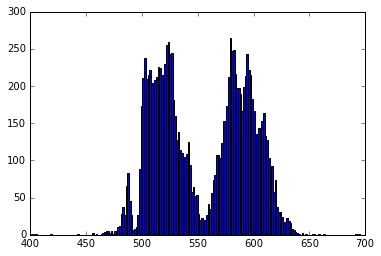

In [21]:
my_hist = plt.hist(pixel_positions[my_dropped_shots==0],bins=np.arange(400,700,1.5))
plt.show()

## Cross validation

### bi_cross SVD number of component estimation

In [23]:
k,score_list = bi_cross_support.score_fast(my_dict[time_camera][my_dropped_shots],
                                           n_iterations=10,
                                           k_list=np.arange(1,43))
#my_prediction = bi_cross_support.predict_vs_k(my_dict[time_camera][my_dropped_shots],
#                                              k_list=np.arange(1,40))



Progress: [####################] 100.0%


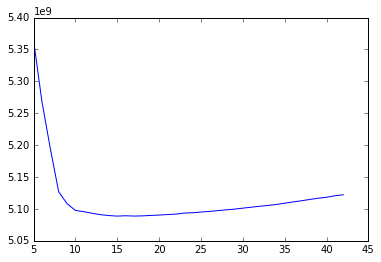

In [34]:
start_k=-4
plt.plot(k[:start_k],np.median(score_list,axis=0)[:start_k])
plt.show()

In [36]:
k[np.argmin(np.median(score_list,axis=0))]

15.0

In [44]:
np.array(my_dict[time_camera][0]

(15015, 1024)

### cross validating mask position

In [56]:
v_full,coefs_full = eig_back.get_background_coefficients(my_dict[time_camera],
                                                     my_dropped_shots,
                                                     my_mask,
                                                     svd_size=15)    

v_full = v_full[:15,:].transpose()

getting background coefficients
dropped shots selected
(2145, 1024)
transpose dot product
eigen values calculated


In [146]:
event_number = 10000
my_mask = my_dict[time_camera][0].astype(bool)
my_mask[0:500]=True
my_mask[500:900]=False
my_mask[900:]=True

this_image  = my_dict[time_camera][event_number][my_mask]

reg = linear_model.LinearRegression()
reg.fit(v_full[my_mask],this_image)
my_score = reg.score(v_full[my_mask],this_image)

cv_score_list = cross_val_score(reg,
                                v_full[my_mask],
                                this_image,
                                cv=10,
                                scoring="neg_mean_squared_error")


In [147]:
cv_score_list

array([ -8129.6833952 , -10685.50466284, -10490.67078487, -10545.80184189,
       -15836.91564115,  -9908.00487895, -16426.08869323, -17477.8593102 ,
       -22386.81853408, -15334.57476984])

In [148]:

mask_width = 400

mask_start_vs_scores = []

for mask_start in np.arange(524,624,1):

    my_mask = np.ones(len( my_dict[time_camera][event_number])).astype(bool)
    my_mask[mask_start:mask_start+mask_width] = False

    this_image  = my_dict[time_camera][event_number][my_mask]
    #my_mask[0:500]=True
    #my_mask[500:900]=False
    #my_mask[900:]=True

   

    reg = linear_model.LinearRegression()
    reg.fit(v_full[my_mask],this_image)
    my_score = reg.score(v_full[my_mask],this_image)

    cv_score_list = cross_val_score(reg,
                                    v_full[my_mask],
                                    this_image,
                                    cv=10,
                                    scoring="neg_mean_squared_error")
    mask_start_vs_scores.append([mask_start,np.mean(cv_score_list)])
    
mask_start_vs_scores= np.array(mask_start_vs_scores).transpose()

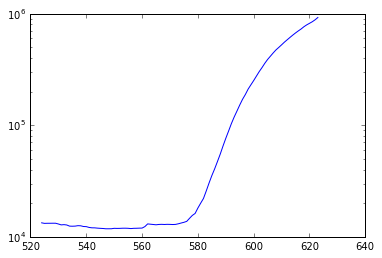

In [149]:
plt.semilogy(mask_start_vs_scores[0],-mask_start_vs_scores[1])
plt.show()

In [150]:
#mask_start = 300
mask_start = mask_start_vs_scores[0][np.argmax(mask_start_vs_scores[1])]
print(mask_start)

547.0


In [151]:
my_mask = np.ones(len( my_dict[time_camera][event_number])).astype(bool)
my_mask[mask_start:mask_start+mask_width] = False

this_image  = my_dict[time_camera][event_number][my_mask]
#my_mask[0:500]=True
#my_mask[500:900]=False
#my_mask[900:]=True



reg = linear_model.LinearRegression()
reg.fit(v_full[my_mask],this_image)


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

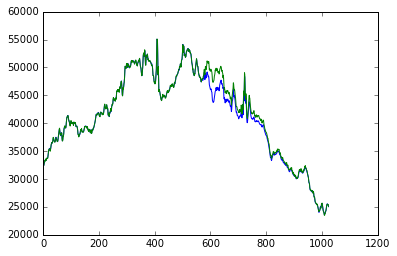

In [152]:
plt.plot(reg.predict(v_full))
plt.plot(my_dict[time_camera][event_number])
plt.show()

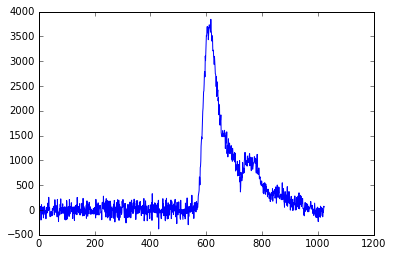

In [153]:
plt.plot(my_dict[time_camera][event_number] - reg.predict(v_full))
plt.show()